In [1]:
git commit -m "Initial commit"

SyntaxError: invalid syntax (2053723443.py, line 1)

In [1]:
from IPython.display import display
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import pandas as pd


#field parameters
field_rows, field_cols = 9, 7
start_row, start_col = 4, 3

# Parameters for cropping and cell splitting
crop_coordinates = (126, 402, 996, 1554)  # Adjust if needed
screenshots_directory = "Screenshots"

rows, cols = 9, 7  # Grid size for splitting image into cells
square_size = 16  # Sample square size within each cell
margins = (5, 5, 5, 5)  # Margins for the sample square
shift_pct = 0.22  # Upward shift percentage for the sample square
# Defined color for each prize category
known_categories = {
    0: np.array([234, 223, 223]),  # 0 score
    1: np.array([155, 209, 203]),  # 1 score
    2: np.array([222, 165, 224]),  # 2 score
    3: np.array([230, 160, 154])   # 3 score
}

def get_latest_screenshot(directory):
    """Returns the path to the most recently created or modified screenshot in the specified directory."""
    files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    latest_file = max(files, key=os.path.getmtime)
    return latest_file

def crop_and_get_latest_screenshot(directory, crop_coordinates):
    """Finds, crops, and returns the latest screenshot in the specified directory."""
    latest_screenshot_path = get_latest_screenshot(directory)
    print("Processing latest screenshot:", latest_screenshot_path)
    
    img = Image.open(latest_screenshot_path)
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    cropped_img = img.crop(crop_coordinates)
    
    return cropped_img

def split_image_into_cells(cropped_img, rows, cols, square_size, margins, shift_pct=0.3):
    """
    Splits the cropped image into individual cells, samples a square from each cell with an upward shift,
    and returns them.

    :param cropped_img: Cropped image of the game field.
    :param rows: Number of rows in the game field.
    :param cols: Number of columns in the game field.
    :param square_size: Size of the square to sample from each cell.
    :param margins: A tuple of (top_margin, right_margin, bottom_margin, left_margin).
    :param shift_pct: Percentage to shift the square upward from the center of the cell.
    """
    width, height = cropped_img.size
    cell_width = width / cols
    cell_height = height / rows
    
    cells = []
    for row in range(rows):
        for col in range(cols):
            center_x = col * cell_width + cell_width / 2
            center_y = row * cell_height + cell_height / 2
            
            # Apply the upward shift
            shift_upward = cell_height * shift_pct
            center_y_shifted = center_y - shift_upward
            
            top_margin, right_margin, bottom_margin, left_margin = margins
            
            left = center_x - square_size / 2 + left_margin
            right = center_x + square_size / 2 - right_margin
            upper = center_y_shifted - square_size / 2 + top_margin
            lower = center_y_shifted + square_size / 2 - bottom_margin
            
            bounding_box = (left, upper, right, lower)
            cell = cropped_img.crop(bounding_box)
            cells.append(cell)
    
    return cells

def measure_cell_color(cell):
    np_cell = np.array(cell)
    avg_color = np.mean(np_cell, axis=(0, 1)).round().astype(int)
    return avg_color

def categorize_cell(cell, categories):
    avg_color = measure_cell_color(cell)
    category_distances = {}
    
    for category, color in categories.items():
        distance = np.linalg.norm(avg_color - color)
        category_distances[category] = round(distance)
    
    closest_category = min(category_distances, key=category_distances.get)
    closest_distance = category_distances[closest_category]
    return closest_category, closest_distance, category_distances

def categorize_and_populate_field(cells, known_categories, rows, cols):
    """
    Categorizes each cell and populates a grid based on the categories.

    :param cells: List of cell images.
    :param known_categories: Dictionary of known categories with their corresponding colors.
    :param rows: Number of rows in the grid.
    :param cols: Number of columns in the grid.
    :return: A 2D list representing the categorized field.
    """
    # Initialize the field variable as a grid of zeros
    field = [[0 for _ in range(cols)] for _ in range(rows)]

    # Categorize each cell and populate the field variable
    for idx, cell in enumerate(cells):
        row = idx // cols  # Determine the cell's row
        col = idx % cols   # Determine the cell's column
        
        category, closest_distance, all_distances = categorize_cell(cell, known_categories)
        
        # Directly use the category as score
        field[row][col] = category

    return field

def debug_analysis(cells, known_categories):
    # Print the total number of cells generated
    print(f"Total cells generated: {len(cells)}")  # This should print 63 for a 9x7 grid

    # Categorize each cell and gather distances
    cells_categories_distances = [categorize_cell(cell, known_categories) for cell in cells]

    # Print categorized cells and distances for analysis
    for idx, (category, closest_distance, all_distances) in enumerate(cells_categories_distances):
        print(f"Cell {idx + 1}: Closest Category = {category}, Closest Distance = {closest_distance}")
        for cat, dist in all_distances.items():
            print(f"    Distance to {cat} score: {dist}")

In [2]:
def visualize_field(field, figsize=(3, 3)):  # Adjusted figsize here
    """Visualizes the game field with customized colors for different cell values."""
    # Define the colors for different cell values
    cmap = ListedColormap(['#EEEEEE', '#4DB6AC', '#9575CD', '#E57373'])
    
    # Define the boundaries for your colormap
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]  # Defines the range for each color
    norm = BoundaryNorm(bounds, cmap.N)
    
    field_array = np.array(field)
    plt.figure(figsize=figsize)  # Use the figsize parameter
    plt.imshow(field_array, cmap=cmap, norm=norm, interpolation='nearest')

    # Add gridlines for better readability
    plt.grid(which='both', color='black', linestyle='-', linewidth=1)
    plt.xticks(np.arange(-0.5, len(field[0]), 1), "")
    plt.yticks(np.arange(-0.5, len(field), 1), "")
    plt.scatter(start_col, start_row, color='blue', s=50)  # s is the size of the point

    # Adjust the tick parameters so that the grid aligns well
    plt.tick_params(
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )

    plt.title('Game Field')
    plt.show()

    
def visualize_field_with_path(field, path, plot_title = 'Unnamed', figsize=(3, 3)):
    """Visualizes the game field with a path line overlaid."""
    # Define the color map for different cell values
    cmap = ListedColormap(['#EEEEEE', '#4DB6AC', '#9575CD', '#E57373'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = BoundaryNorm(bounds, cmap.N)

    # Convert the field to a NumPy array for easier plotting
    field_array = np.array(field)
    plt.figure(figsize=figsize)
    plt.imshow(field_array, cmap=cmap, norm=norm, interpolation='nearest')

    # Extract path coordinates based on the new path format
    path_coords = extract_path_coordinates(path)

    # If there are path coordinates, plot the path
    if path_coords:
        y_coords, x_coords = zip(*path_coords)  # Note: plt.plot expects x and y in this order
        plt.plot(x_coords, y_coords, color='blue', linewidth=2, marker=',', markersize=5, markerfacecolor='red')

    # Add gridlines for better readability
    plt.grid(which='both', color='black', linestyle='-', linewidth=1)
    plt.xticks(np.arange(-0.5, len(field[0]), 1), "")
    plt.yticks(np.arange(-0.5, len(field), 1), "")
    plt.scatter(start_col, start_row, color='blue', s=50)  # s is the size of the point
    
    plt.tick_params(
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )

    plt.title(plot_title)
    plt.show()

def extract_path_coordinates(path):
    """Extracts and orders the path coordinates from the path string."""
    path_coords = [(start_row, start_col)]  # Include the starting point
    current_row, current_col = start_row, start_col
    for move in path:
        if move == 'U':
            current_row -= 1
        elif move == 'D':
            current_row += 1
        elif move == 'L':
            current_col -= 1
        elif move == 'R':
            current_col += 1
        path_coords.append((current_row, current_col))
    return path_coords

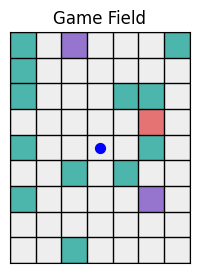

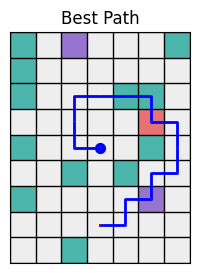

In [3]:
# Example usage with a sample path string
sample_field = [
    [1, 0, 2, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 3, 0],
    [1, 0, 0, 0, 0, 1, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0]
]

sample_path = "LUURRRDRDDLDLDL"  # Example path

visualize_field(sample_field)
visualize_field_with_path(sample_field, sample_path,'Best Path')

Processing latest screenshot: Screenshots\HD-Player_175KwABB7n.png


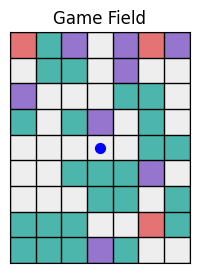

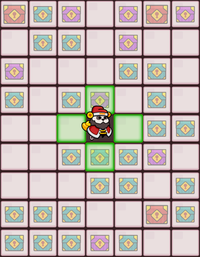

In [4]:
# 1. Crop the latest screenshot
cropped_img = crop_and_get_latest_screenshot(screenshots_directory, crop_coordinates)

# After splitting the cropped image into cells
cells = split_image_into_cells(cropped_img, rows, cols, square_size, margins, shift_pct)

# Call the function to categorize cells and populate the field
field = categorize_and_populate_field(cells, known_categories, rows, cols)


visualize_field(field)
display(cropped_img.resize((200, 257), Image.LANCZOS))

#debug_analysis(cells, known_categories)

In [3]:
def explore_field_paths(field, start_row=4, start_col=3, max_steps=15):
    field_rows, field_cols = len(field), len(field[0])
    directions = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}
    
    visited = [[False for _ in range(field_cols)] for _ in range(field_rows)]
    paths = []

    def dfs(row, col, steps, path, cell_values):
        if steps == max_steps:
            paths.append({
                'path': path,
                'cell_values': cell_values
            })
            return
        if not (0 <= row < field_rows and 0 <= col < field_cols) or visited[row][col]:
            return
        
        visited[row][col] = True
        for direction, (dr, dc) in directions.items():
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < field_rows and 0 <= new_col < field_cols and not visited[new_row][new_col]:
                dfs(new_row, new_col, steps + 1, path + direction, cell_values + (field[new_row][new_col],))
        visited[row][col] = False  # Backtrack

    dfs(start_row, start_col, 0, "", ())

    return paths

In [23]:
paths_inf = explore_field_paths(field)
print(len(paths_inf))
paths_inf[0]

507328


{'path': 'UUUULDDDDDDDDLU',
 'cell_values': (2, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1)}

In [24]:
def add_path_analysis(paths, start_row=4, start_col=3):
    directions = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}
    
    for path_dict in paths:
        # Initialize counts for each cell type
        cell_counts = {0: 0, 1: 0, 2: 0, 3: 0}
        # Calculate the counts of each cell type
        for cell_value in path_dict['cell_values']:
            cell_counts[cell_value] += 1

        # Calculate the sum of points based on cell types
        sum_of_points = (cell_counts[3] * 3) + (cell_counts[2] * 2) + (cell_counts[1] * 1)
        
        # Convert path to absolute coordinates
        current_row, current_col = start_row, start_col
        coordinates = [(current_row, current_col)]  # Include the starting position
        #coordinates = []  # The starting position not included
        for direction in path_dict['path']:
            dr, dc = directions[direction]
            current_row += dr
            current_col += dc
            coordinates.append((current_row, current_col))

        # Update the dictionary with the new properties
        path_dict['cell_counts'] = cell_counts
        path_dict['sum_of_points'] = sum_of_points
        path_dict['coordinates'] = coordinates

    return paths

In [25]:
paths_inf = add_path_analysis(paths_inf)
paths_inf[0]

{'path': 'UUUULDDDDDDDDLU',
 'cell_values': (2, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1),
 'cell_counts': {0: 6, 1: 7, 2: 2, 3: 0},
 'sum_of_points': 11,
 'coordinates': [(4, 3),
  (3, 3),
  (2, 3),
  (1, 3),
  (0, 3),
  (0, 2),
  (1, 2),
  (2, 2),
  (3, 2),
  (4, 2),
  (5, 2),
  (6, 2),
  (7, 2),
  (8, 2),
  (8, 1),
  (7, 1)]}

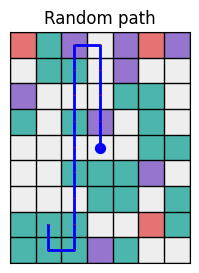

In [26]:
#print(len(paths_inf))
visualize_field_with_path(field, paths_inf[0]['path'],'Random path')

In [27]:
def find_extreme_paths(paths_info):
    max_points_path = None
    min_points_path = None
    max_points = -1
    min_points = float('inf')
    priority_path_3 = None
    priority_path_3_counts = (-1, -1, -1)  # For #3, #2, #1 priority
    priority_path_2 = None
    priority_path_2_counts = (-1, -1, -1)  # For #2, #3, #1 priority
    priority_path_1 = None
    priority_path_1_counts = (-1, -1, -1)  # For #1, #3, #2 priority
    min_empty_path = None
    min_empty_count = float('inf')
    
    for path_dict in paths_info:
        points_sum = path_dict['sum_of_points']
        
        if points_sum > max_points:
            max_points = points_sum
            max_points_path = path_dict
        
        if points_sum < min_points:
            min_points = points_sum
            min_points_path = path_dict

        cell_counts = path_dict['cell_counts']
        # Update priority paths
        counts_3_priority = (cell_counts[3], cell_counts[2], cell_counts[1])
        if counts_3_priority > priority_path_3_counts:
            priority_path_3_counts = counts_3_priority
            priority_path_3 = path_dict
        
        counts_2_priority = (cell_counts[2], cell_counts[3], cell_counts[1])
        if counts_2_priority > priority_path_2_counts:
            priority_path_2_counts = counts_2_priority
            priority_path_2 = path_dict
        
        counts_1_priority = (cell_counts[1], cell_counts[3], cell_counts[2])
        if counts_1_priority > priority_path_1_counts:
            priority_path_1_counts = counts_1_priority
            priority_path_1 = path_dict

        # Update path with minimum empty cells
        if cell_counts[0] < min_empty_count:
            min_empty_count = cell_counts[0]
            min_empty_path = path_dict
    
    return {
        'max_points_path': max_points_path,
        'min_points_path': min_points_path,
        'priority_path_3': priority_path_3,
        'priority_path_2': priority_path_2,
        'priority_path_1': priority_path_1,
        'min_empty_path': min_empty_path
    }

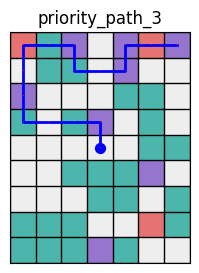

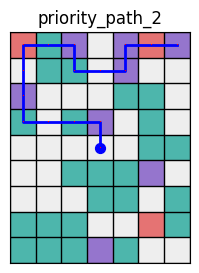

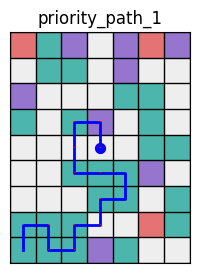

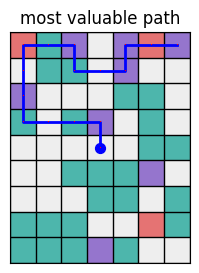

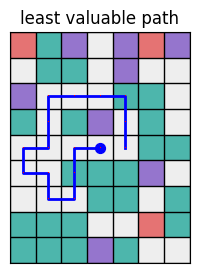

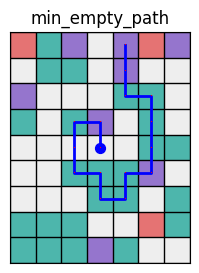

In [25]:
paths_analysis = find_extreme_paths(paths_inf)
visualize_field_with_path(field, paths_analysis['priority_path_3']['path'],'priority_path_3')
visualize_field_with_path(field, paths_analysis['priority_path_2']['path'],'priority_path_2')
visualize_field_with_path(field, paths_analysis['priority_path_1']['path'],'priority_path_1')
visualize_field_with_path(field, paths_analysis['max_points_path']['path'],'most valuable path')
visualize_field_with_path(field, paths_analysis['min_points_path']['path'],'least valuable path')
visualize_field_with_path(field, paths_analysis['min_empty_path']['path'],'min_empty_path')

In [28]:
def update_paths_with_uniqueness_info_and_id(paths_inf):
    unique_keys_count = {}
    unique_keys_id = {}
    current_id = 0

    # First pass: Identify unique paths and assign IDs
    for path_info in paths_inf:
        unique_key = tuple(sorted(path_info['coordinates']))
        if unique_key not in unique_keys_id:
            unique_keys_id[unique_key] = current_id
            current_id += 1
        unique_keys_count[unique_key] = unique_keys_count.get(unique_key, 0) + 1

    # Second pass: Update original dictionaries with uniqueness info and unique IDs
    for path_info in paths_inf:
        unique_key = tuple(sorted(path_info['coordinates']))
        twins_paths_count = unique_keys_count[unique_key]
        path_info['is_unique'] = (twins_paths_count == 1)
        path_info['twins_paths_count'] = twins_paths_count
        path_info['cells_set_unique_id'] = unique_keys_id[unique_key]

update_paths_with_uniqueness_info_and_id(paths_inf)
paths_inf[-2]

{'path': 'RRRDLLLLLLDRRRD',
 'cell_values': (0, 1, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0),
 'cell_counts': {0: 8, 1: 6, 2: 1, 3: 0},
 'sum_of_points': 8,
 'coordinates': [(4, 3),
  (4, 4),
  (4, 5),
  (4, 6),
  (5, 6),
  (5, 5),
  (5, 4),
  (5, 3),
  (5, 2),
  (5, 1),
  (5, 0),
  (6, 0),
  (6, 1),
  (6, 2),
  (6, 3),
  (7, 3)],
 'is_unique': True,
 'twins_paths_count': 1,
 'cells_set_unique_id': 348735}

In [ ]:
def get_unique_ids_by_twins_count(paths_inf, twins_paths_count):
    unique_ids = set()
    for path in paths_inf:
        if path.get('twins_paths_count', 0) == twins_paths_count:
            unique_ids.add(path.get('cells_set_unique_id'))
    return list(unique_ids)

def get_paths_by_unique_id(paths_inf, unique_id):
    matching_paths = [path for path in paths_inf if path.get('cells_set_unique_id') == unique_id]
    return matching_paths

In [71]:
unique_ids_for_twins_count = get_unique_ids_by_twins_count(paths_inf, 13)
#print(unique_ids_for_twins_count)

In [ ]:
for i, path_dict in enumerate(unique_ids_for_twins_count):
    paths_with_specific_unique_id = get_paths_by_unique_id(paths_inf, path_dict)
    label = f"Path {i}"
    visualize_field_with_path(field, paths_with_specific_unique_id[0]['path'], label)

In [ ]:
def count_unique_sets_by_identical_count(paths_inf):
    # Dictionary to count unique cell sets occurrences
    unique_sets_counts = {}
    
    # Dictionary to track unique cell sets
    unique_sets = {}
    
    for path_info in paths_inf:
        # Create a unique key for the set of coordinates
        unique_key = tuple(sorted(path_info['coordinates']))
        
        if unique_key not in unique_sets:
            # If this is a new set, add it with its identical_path_count
            unique_sets[unique_key] = path_info['identical_path_count']
            
            # Initialize or increment the count for this identical_path_count
            if path_info['identical_path_count'] in unique_sets_counts:
                unique_sets_counts[path_info['identical_path_count']] += 1
            else:
                unique_sets_counts[path_info['identical_path_count']] = 1

    # Sorting the counts by identical_path_count
    sorted_counts = sorted(unique_sets_counts.items())
    return sorted_counts

def visualize_frequency(sorted_counts, title='Frequency of Unique Cell Sets by Identical Path Count', start_count=1, end_count=None):
    # If end_count is not provided, set it to the maximum count in the data
    if end_count is None:
        end_count = max(sorted_counts, key=lambda x: x[0])[0]

    # Filter the sorted_counts to include only the specified range
    filtered_counts = [item for item in sorted_counts if start_count <= item[0] <= end_count]

    if not filtered_counts:  # Check if the filtered list is empty
        print(f"No data available for the range {start_count} to {end_count}.")
        return

    # Unpack the filtered counts into separate lists
    counts, frequencies = zip(*filtered_counts)  

    plt.figure(figsize=(10, 6))
    plt.bar(counts, frequencies, color='#4DB6AC')
    
    plt.title(title)
    plt.xlabel('Identical Path Count')
    plt.ylabel('Frequency')
    plt.xticks(counts)
    plt.grid(axis='y', linestyle='--')
    
    plt.show()

sorted_counts = count_unique_sets_by_identical_count(paths_inf)
visualize_frequency(sorted_counts, title='Frequency of Identical Path Counts', start_count=7, end_count=None)

In [16]:
sorted_counts

[(1, 267716),
 (2, 49570),
 (3, 14912),
 (4, 7952),
 (5, 2780),
 (6, 2168),
 (7, 928),
 (8, 826),
 (9, 416),
 (10, 340),
 (11, 248),
 (12, 224),
 (13, 128),
 (14, 92),
 (15, 76),
 (16, 48),
 (17, 48),
 (18, 20),
 (19, 48),
 (20, 36),
 (21, 124),
 (23, 12),
 (25, 8),
 (26, 4),
 (36, 4),
 (38, 4),
 (52, 4)]

In [11]:
def analyze_path_usage(paths):
    field_usage = [[0 for _ in range(field_cols)] for __ in range(field_rows)]
    
    for path in paths:
        for coordinate in path['coordinates']:
            row, col = coordinate
            field_usage[row][col] += 1
    
    return field_usage

In [12]:
def visualize_field_usage(field_usage, figsize=(5, 8), interpolation='none'):
    """Visualizes the field usage with overlay of usage counts."""
    cmap = plt.get_cmap('turbo')
    max_usage = np.max(field_usage)
    
    # Normalize the usage values to scale between 0 and the length of the colormap minus one
    normalized_usage = np.array(field_usage) / max_usage
    
    plt.figure(figsize=figsize)
    im = plt.imshow(normalized_usage, cmap=cmap, interpolation=interpolation)
    
    # Add gridlines for better readability
    plt.grid(which='both', color='black', linestyle='-', linewidth=0.2)
    plt.xticks(np.arange(-0.5, len(field_usage[0]), 1), "")
    plt.yticks(np.arange(-0.5, len(field_usage), 1), "")
    
    # Overlay usage counts
    for i in range(len(field_usage)):
        for j in range(len(field_usage[0])):
            plt.text(j, i, f'{field_usage[i][j]}', ha='center', va='center', color='black')
    
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('Field Usage Visualization')
    plt.show()

In [14]:
def filter_paths_by_points(paths, points):
    filtered_paths = [path for path in paths if path['sum_of_points'] == points]
    return filtered_paths

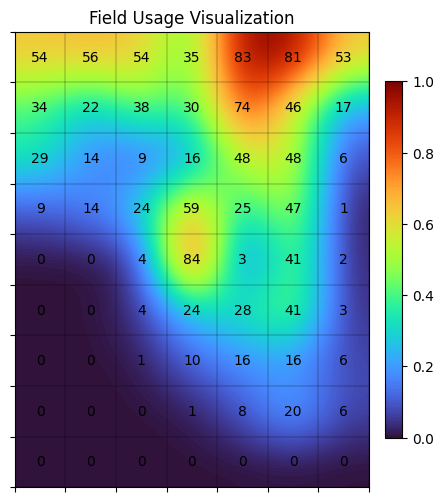

In [15]:
#visualize_field_usage(field_usage)
field_usage = analyze_path_usage(paths_inf)
paths_inf_filtered = filter_paths_by_points(paths_inf, 20)
field_usage_filtered = analyze_path_usage(paths_inf_filtered)
#visualize_field(field)
visualize_field_usage(field_usage_filtered,interpolation='bicubic')

In [16]:
#Colormap animation function

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.animation as animation

# Assuming 'paths_inf' is your original list of path dictionaries and the other necessary functions are defined

def animate_field_usage_for_points_sums(paths_inf, points_range, figsize=(5, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    cmap = plt.get_cmap('turbo')

    def animate(points):
        ax.clear()
        filtered_paths = filter_paths_by_points(paths_inf, points)
        field_usage_filtered = analyze_path_usage(filtered_paths)
        max_usage = np.max(field_usage_filtered) if np.max(field_usage_filtered) != 0 else 1
        normalized_usage = np.array(field_usage_filtered) / max_usage
        
        im = ax.imshow(normalized_usage, cmap=cmap, interpolation='hermite')
        ax.set_title(f'Field Usage for Paths with {points} Points')

        # Overlay usage counts
#        for i in range(len(field_usage_filtered)):
#            for j in range(len(field_usage_filtered[0])):
#                ax.text(j, i, f'{field_usage_filtered[i][j]}', ha='center', va='center', color='black')
        
        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
        fig.tight_layout()  # Adjust the layout to not have large white spaces

    # Creating animation
    ani = animation.FuncAnimation(fig, animate, frames=points_range, repeat=False)

    plt.close()  # Prevents duplicate display of the last frame in Jupyter notebooks
    return ani

# Assuming 'paths_inf' is your data and points_range is from 2 to 20 (inclusive)
points_range = range(2, 21)
ani = animate_field_usage_for_points_sums(paths_inf, points_range)

# To display the animation in a Jupyter notebook
from IPython.display import HTML
HTML(ani.to_jshtml())

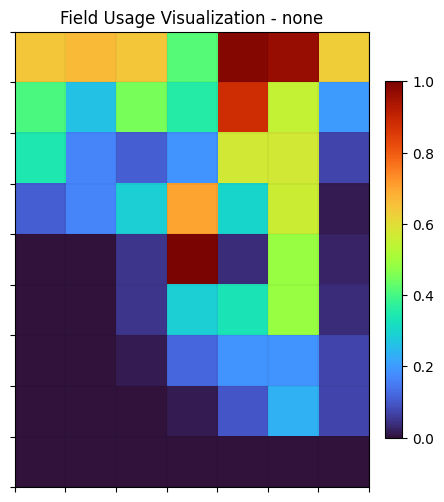

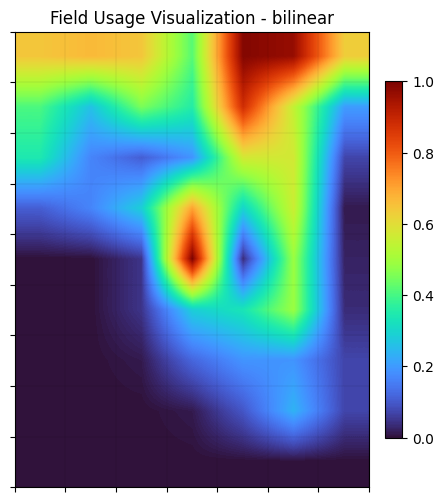

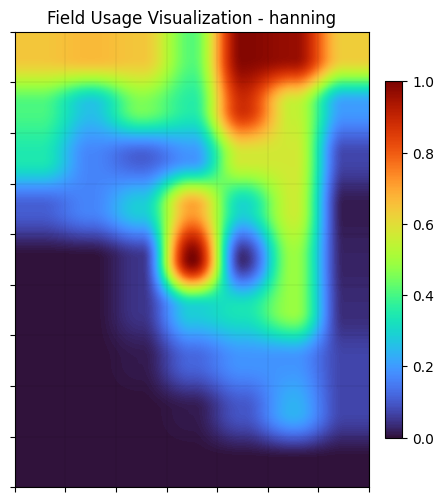

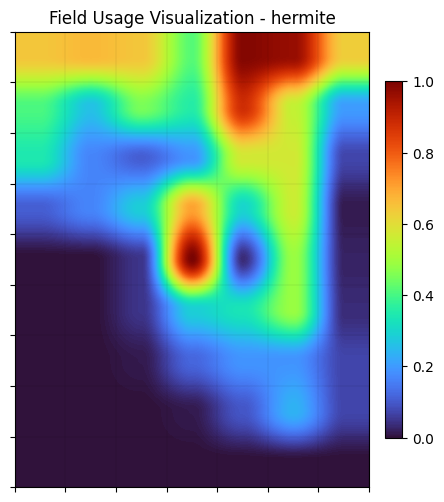

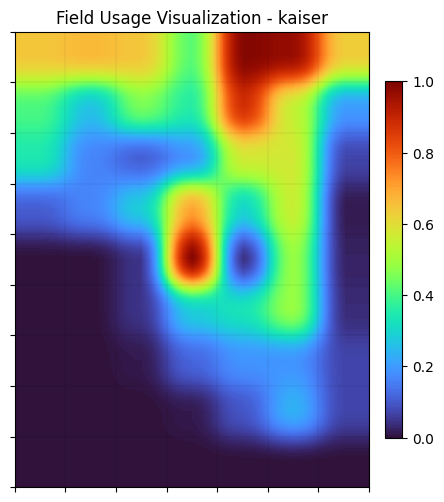

In [17]:
#Demonstrating function for generating vizualisations with different interpolation

def visualize_field_usage(field_usage, figsize=(5, 8), interpolation='none'):
    """Visualizes the field usage with overlay of usage counts."""
    cmap = plt.get_cmap('turbo')
    max_usage = np.max(field_usage)
    normalized_usage = np.array(field_usage) / max_usage
    plt.figure(figsize=figsize)
    im = plt.imshow(normalized_usage, cmap=cmap, interpolation=interpolation)
    plt.grid(which='both', color='black', linestyle='-', linewidth=0.05)
    plt.xticks(np.arange(-0.5, len(field_usage[0]), 1), "")
    plt.yticks(np.arange(-0.5, len(field_usage), 1), "")
#    for i in range(len(field_usage)):
#        for j in range(len(field_usage[0])):
#            plt.text(j, i, f'{field_usage[i][j]}', ha='center', va='center', color='black')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f'Field Usage Visualization - {interpolation}')
    plt.show()

# List of interpolation types to visualize
interpolation_types = ['none', 'bilinear','hanning', 'hermite', 'kaiser']

# Generate visualization for each interpolation type
for interpolation in interpolation_types:
    visualize_field_usage(field_usage_filtered, interpolation=interpolation)

In [18]:
def build_efficient_graph_from_paths(paths):
    # Initialize the graph as an empty dictionary
    graph = {}
    
    for path_dict in paths:
        coordinates = path_dict['coordinates']
        for i in range(1, len(coordinates)):
            prev_coord = coordinates[i - 1]
            curr_coord = coordinates[i]

            # Ensure the entry for the previous cell exists in the graph
            if prev_coord not in graph:
                graph[prev_coord] = {}

            # Update the connection count between the previous and current cell
            if curr_coord in graph[prev_coord]:
                graph[prev_coord][curr_coord] += 1
            else:
                graph[prev_coord][curr_coord] = 1
    
    return graph

In [19]:
def build_efficient_graph_from_paths(paths):
    graph = {}

    for path_dict in paths:
        coordinates = path_dict['coordinates']
        for i in range(1, len(coordinates)):
            # Sort the tuple to ensure direction-independence
            # This makes (A, B) and (B, A) treated the same
            connection = tuple(sorted([coordinates[i - 1], coordinates[i]]))

            # Increment the connection count
            if connection in graph:
                graph[connection] += 1
            else:
                graph[connection] = 1

    return graph


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection

def visualize_field_with_connections(field, graph, plot_title='Unnamed', figsize=(7, 9)):
    cmap = ListedColormap(['#EEEEEE', '#4DB6AC', '#9575CD', '#E57373'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = BoundaryNorm(bounds, cmap.N)
    
    field_array = np.array(field)
    plt.figure(figsize=figsize)
    plt.imshow(field_array, cmap=cmap, norm=norm, interpolation='nearest')

    # Extract all values to find the max for scaling
    max_value = max(graph.values())

    lines = []
    linewidths = []

    # Scale factor - adjust this as needed
    scale_factor = 10 / max_value

    for (start, end), value in graph.items():
        start_x, start_y = start[1], start[0]
        end_x, end_y = end[1], end[0]
        lines.append([(start_x, start_y), (end_x, end_y)])
        linewidths.append(value * scale_factor)  # Apply scaling

    lc = LineCollection(lines, linewidths=linewidths, colors='blue', alpha=0.5)
    plt.gca().add_collection(lc)

    plt.grid(which='both', color='black', linestyle='-', linewidth=1)
    plt.xticks(np.arange(-0.5, len(field[0]), 1), "")
    plt.yticks(np.arange(-0.5, len(field), 1), "")
    plt.tick_params(
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )

    plt.title(plot_title)
    plt.show()

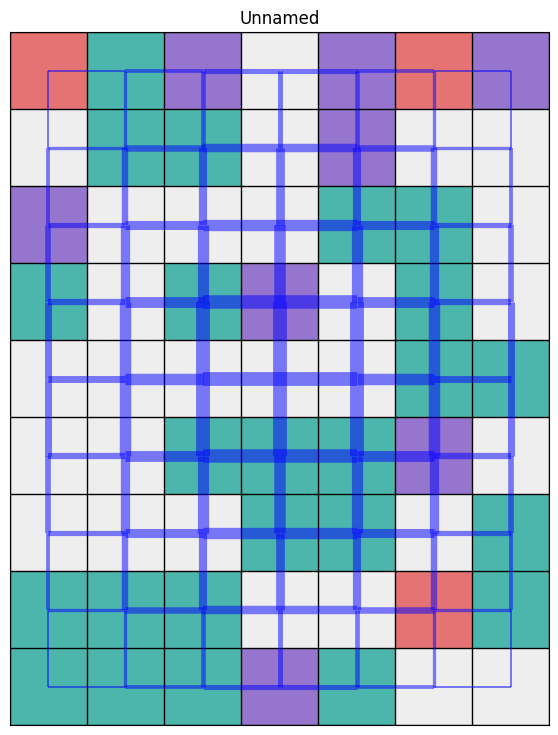

In [21]:
#cells_connections_graph = build_efficient_graph_from_paths(filter_paths_by_points(paths_inf, 11))
cells_connections_graph = build_efficient_graph_from_paths(paths_inf)
visualize_field_with_connections(field, cells_connections_graph)

In [22]:
import numpy as np

# Assuming 'graph' is your direction-independent graph data
# and you know the maximum indices for your grid
max_row_index = 8  # Adjust based on your data
max_col_index = 6  # Adjust based on your data

# Initialize an empty adjacency matrix
adj_matrix = np.zeros((max_row_index + 1) * (max_col_index + 1), 
                      (max_row_index + 1) * (max_col_index + 1))

# Fill the adjacency matrix with your graph data
for ((start_row, start_col), (end_row, end_col)), value in cells_connections_graph.items():
    start_index = start_row * (max_col_index + 1) + start_col
    end_index = end_row * (max_col_index + 1) + end_col
    adj_matrix[start_index, end_index] = value
    adj_matrix[end_index, start_index] = value  # Since it's direction-independent
    
from matplotlib import pyplot as plt
from chord import Chord

Chord(adj_matrix).show()


TypeError: Cannot interpret '63' as a data type